In [1]:
import pandas as pd 
import numpy as np 
import re
import nltk 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
#### Setting up and preprocessing 

# read data
data = pd.read_csv('D:\\Sentiment Analysis Dataset.csv', error_bad_lines=False, index_col=0)

# Download english stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')

# convert all to lowercase
data['SentimentText'] = data['SentimentText'].apply(lambda x: x.lower())
# remove special characters
data['SentimentText'] = data['SentimentText'].apply(lambda x: re.sub(r'\W', ' ', x))
# remove single characters
data['SentimentText'] = data['SentimentText'].apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x))
# remove single characters from the start
data['SentimentText'] = data['SentimentText'].apply(lambda x: re.sub(r'\^[a-zA-Z]\s+', ' ', x))
# substitute multiple spaces with one space
data['SentimentText'] = data['SentimentText'].apply(lambda x: re.sub(r'\s+', ' ', x, flags=re.I))


b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'
C:\Users\ytolo\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ytolo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
##### Task 1. Top 10 Positive and negative words.
# Positive and negative words are defined as "words more frequent with positive and negative labels respectively"

positive_words = defaultdict(int)
negative_words = defaultdict(int)

positive = data[data['Sentiment'] == 1]['SentimentText']
negative = data[data['Sentiment'] == 0]['SentimentText']

for tweet in positive:
    for word in tweet.split():
        if (len(word) > 1) and (word not in stopwords):
            positive_words[word] += 1

for tweet in negative:
    for word in tweet.split():
        if (len(word) > 1) and (word not in stopwords):
            negative_words[word] += 1
    

sorted_positive = sorted(positive_words.items(), key=lambda kv: -kv[1])
sorted_negative = sorted(negative_words.items(), key=lambda kv: -kv[1])

In [8]:
print('Top 10 positive words are')
for word in sorted_positive[:10]:
    print(word)

print('________________')
    
print('Top 10 negative words are')
for word in sorted_negative[:10]:
    print(word)

Top 10 positive words are
('good', 60795)
('love', 47573)
('http', 46223)
('day', 45951)
('quot', 45471)
('like', 37451)
('get', 36181)
('lol', 36000)
('com', 34833)
('thanks', 34434)
________________
Top 10 negative words are
('get', 45435)
('go', 45115)
('work', 44065)
('like', 40882)
('day', 39498)
('today', 37859)
('going', 33416)
('got', 33031)
('back', 32602)
('really', 31172)


C:\Users\ytolo\Anaconda3\lib\site-packages\pandas\plotting\_core.py:998: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


Text(0, 0.5, 'Frequency')

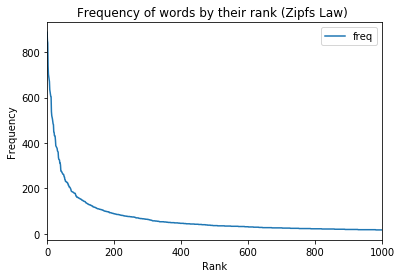

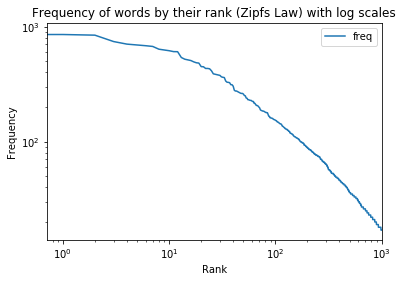

In [12]:
##### Task 2. Zipf's law
all_tweets = data['SentimentText']
all_word_freqs = defaultdict(int)
for tweet in all_tweets:
    for word in tweet.split():
        if (len(word) > 1) and (word not in stopwords):
            all_word_freqs[word] += 1

sorted_freqs = sorted(all_word_freqs.items(), key=lambda kv: -kv[1])

# Select top 1000 words and pack them into a dataframe indexed by their frequency
id_freq = {i: sorted_freqs[i] for i in range(1000)}
freq_df = pd.DataFrame.from_dict(id_freq, orient = 'index', columns=['word', 'freq'])
freq_df = freq_df.reset_index()

ax = freq_df.plot(x = 'index', y = 'freq', title='Frequency of words by their rank (Zipfs Law) ')
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")

ax = freq_df.plot(x = 'index', y = 'freq', logx = True, logy = True, title='Frequency of words by their rank (Zipfs Law) with log scales')
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")


# Task 3. Write a simple classifier to predict sentiment

## My approach:
1. Sample 1% of the data, because otherwise it takes too much memory and takes too long to fit the model. I am fully aware of the ridiculousness of using only 1% of the available data, but this is a proof-of-concept excersice. 
2. The main idea for this simple classifier is to use term frequency–inverse document frequency statistic for extracting features out of raw words. 
    * tf-idf is a "classsical" approach to NLP, similar to a bag-of-words model. The big difference is that the tf–idf value of a word is directly proportional to the number of times a word appears in a document (tweet) and is inversely proportional to the number of documents in the corpus (dataset) that contain the word, which adjusts for the fact that some words are generally more frequent than others. 
    * Therefore we are able to use information about word's relative frequency in a tweet while taking into account that a word might be frequent globally. 
3. Using tf–idf values of tweets as features, we train a random forest classifier to predict sentiment of a tweet. 

In [11]:
##### Task 3. Simple classifier to predict sentiment

# Sample 1% of data to have enough memory and for the runtime to be on the order of minutes and not hours. 
# Please change according to your machine specs. 
data = data.sample(frac = 0.01)
features = data['SentimentText'].values
targets = data['Sentiment'].values

# Create a tf–idf out of the "raw" tweets
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords)
processed_features = vectorizer.fit_transform(features).toarray()

# Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(processed_features, targets, test_size=0.3, random_state=0)

# Fit the RF classifier
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

# Check how well it performs on test data
text_classifier.score(X_test, y_test)

0.7018581081081081

# 70% Accuracy on 1% of the data. 
## What can be done to the current apporach (RF classifier) improve the results?
1. Have more RAM and a better CPU to train on the full dataset:)
2. Spend more time on figuring out what words are to be filtered out. Currently we filter out 1-letter words and words which are found in the stopwords list provided by nltk.
3. Apply Stemming and Lemmatization techniques to raw tweets.

### Alternative approach
1. Switch to word embeddings (e.g. word2vec) instead of tf-idf to featurize the tweets. Word embeddings capture much more information and allow for comparisons between word's semantic loading, which is not available for tf-idf approach, as it only works with a word's frequency of occurence in a document/corpus.
2. Switch to a deep learning based classifier. A bidrectional RNN would be able to capture the length relationship that tf-idf is not able to capture. E.g. a sentence "this was not a very well made and thought through movie" would likely be predicted as positive by tf-idf based classifier because it can't model the sentence flow (it's a bag-of-words-like model in the end of the day). An RNN-based classifier would have no problem with classifiyng this as a negative sentiment exactly because it can model these sequence-based relationships.